# Importing Libraries

In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import pickle
from scipy.stats import binomtest


# Loading Root Files Into Pandas Dataframes

In [2]:
# let's open a nu_overlay file and examine the contents

f_nu_overlay = uproot.open("data/checkout_prodgenie_bnb_nu_overlay_run1_PF.root")
f_nu_overlay.keys()


['wcpselection;1',
 'wcpselection/T_PFeval;69',
 'wcpselection/T_PFeval;68',
 'wcpselection/T_BDTvars;13',
 'wcpselection/T_BDTvars;12',
 'wcpselection/T_eval;2',
 'wcpselection/T_eval;1',
 'wcpselection/T_pot;1',
 'wcpselection/T_KINEvars;1']

In [3]:
already_printed_keys = []

for key in f_nu_overlay["wcpselection"].items():
    key_name = key[0].split(";")[0]
    if key_name not in already_printed_keys: # sometimes a TTree is repeated, we ignore duplicates
        print("\nPrinting variables in TTree: ", key[0].split(";")[0])
        print(f_nu_overlay["wcpselection"][key[0]].keys())
        already_printed_keys.append(key_name)


Printing variables in TTree:  T_PFeval
['run', 'subrun', 'event', 'neutrino_type', 'reco_nuvtxX', 'reco_nuvtxY', 'reco_nuvtxZ', 'reco_showervtxX', 'reco_showervtxY', 'reco_showervtxZ', 'reco_showerKE', 'reco_muonvtxX', 'reco_muonvtxY', 'reco_muonvtxZ', 'reco_muonMomentum', 'nuvtx_diff', 'showervtx_diff', 'muonvtx_diff', 'truth_corr_nuvtxX', 'truth_corr_nuvtxY', 'truth_corr_nuvtxZ', 'truth_corr_showervtxX', 'truth_corr_showervtxY', 'truth_corr_showervtxZ', 'truth_showerKE', 'truth_corr_muonvtxX', 'truth_corr_muonvtxY', 'truth_corr_muonvtxZ', 'truth_muonvtxX', 'truth_muonvtxY', 'truth_muonvtxZ', 'truth_muonendX', 'truth_muonendY', 'truth_muonendZ', 'truth_muonMomentum', 'truth_nuEnergy', 'truth_energyInside', 'truth_electronInside', 'truth_nuPdg', 'truth_isCC', 'truth_vtxX', 'truth_vtxY', 'truth_vtxZ', 'truth_nuTime', 'truth_nuIntType', 'truth_NCDelta', 'truth_NprimPio', 'truth_pio_energy_1', 'truth_pio_energy_2', 'truth_pio_angle', 'reco_protonMomentum', 'reco_showerMomentum', 'reco_Np

## Choosing Variables To Load

In [4]:
T_bdt_vars = [              # variables involved with BDT training (if you want to train your own BDT, lots of these variables will be useful)
                            # many of these variables describe specific features of the WC spacepoints using this code: https://github.com/BNLIF/wire-cell-pid/blob/master/src/NeutrinoID_nue_tagger.h
                            # here, we just include higher level outputs:
    "nue_score",                    # BDT score for nue selection, used for the WC inclusive nueCC analysis
    "numu_score",                   # BDT score for numu selection, used for the WC inclusive numuCC selections
    "nc_delta_score",               # BDT score for NC Delta selection
    "nc_pio_score",                 # BDT score for NC pi0 selection
    "numu_cc_flag",                 # flag, -1 means not generic selected, 0 means generic selected, 1 means cut-based numuCC selected. We often use "numu_cc_flag >= 0" to apply generic neutrino selection.
]

T_eval_vars = [             # variables involved with low level reconstruction and truth information
    "run",                          # run number
    "subrun",                       # subrun number
    "event",                        # event number
    "match_isFC",                   # reconstructed cluster is fully contained (FC), boolean
    "truth_nuEnergy",               # true neutrino energy (MeV)
    "truth_nuPdg",                  # true neutrino pdg code
    "truth_isCC",                   # true interaction type is charged current, boolean
    "match_completeness_energy",    # the true energy deposited in the clusters that are 3D-matched with the reconstructed neutrino clusters (MeV)
    "truth_energyInside",           # the true energy deposited in the TPC Fiducial Volume (MeV)
    "truth_vtxInside",              # boolean, true neutrino vertex is inside the TPC Fiducial Volume
    "truth_vtxX",                   # true neutrino vertex x (cm)
    "truth_vtxY",                   # true neutrino vertex y (cm)
    "truth_vtxZ",                   # true neutrino vertex z (cm)
    "weight_cv",                    # untuned GENIE event weight
    "weight_spline",                # additional MicroBooNE Tune weight
]
T_eval_data_vars = [        # same as above, but for data files we do not attempt to load any truth information
    "run",
    "subrun",
    "event",
    "match_isFC",
]

T_kine_vars = [             # variables involved with kinematic reconstruction
    "kine_reco_Enu",                # reconstructed neutrino energy (MeV). "kine_reco_Enu > 0" is another way to apply generic neutrino selection.
    "kine_energy_particle",         # energy of each reco particle
    "kine_particle_type",           # pdg code of each reco particle
]

T_pf_vars = [               # variables involved with individual particles
    "truth_NprimPio",
    "truth_NCDelta",
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_muonMomentum",            # reconstructed muon momentum 4-vector (p_x, p_y, p_z, p_t), in (GeV/c, GeV/c, GeV/c, GeV)

    # These variables are related to individual true particles
    "truth_Ntrack",
    "truth_id",
    "truth_pdg",
    "truth_mother",
    "truth_startMomentum",
    "truth_startXYZT",
    "truth_endXYZT",

    # These variables are related to individual reco particles
    "reco_Ntrack",
    "reco_id",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
    "reco_startXYZT",
    "reco_endXYZT",
]
T_pf_data_vars = [          # same as above, but for data files we do not attempt to load any truth information
    "reco_nuvtxX",
    "reco_nuvtxY",
    "reco_nuvtxZ",
    "reco_muonMomentum",
    "reco_Ntrack",
    "reco_id",
    "reco_pdg",
    "reco_mother",
    "reco_startMomentum",
    "reco_startXYZT",
    "reco_endXYZT",
]


## Making Dataframes

In [5]:
print("loading root files...")

f = uproot.open("data/checkout_prodgenie_bnb_nu_overlay_run1_PF.root")["wcpselection"] # loading the nu_overlay file
vars = {}
vars.update(f["T_BDTvars"].arrays(T_bdt_vars, library="np"))
vars.update(f["T_eval"].arrays(T_eval_vars, library="np"))
vars.update(f["T_KINEvars"].arrays(T_kine_vars, library="np"))
vars.update(f["T_PFeval"].arrays(T_pf_vars, library="np"))
nu_overlay_file_POT = np.sum(f["T_pot"].arrays("pot_tor875good", library="np")["pot_tor875good"])
for col in vars:
    vars[col] = vars[col].tolist()
nu_overlay_df = pd.DataFrame(vars)
nu_overlay_df["file"] = "nu_overlay"
print(f"loaded nu_overlay file, {len(nu_overlay_df)} events, {nu_overlay_file_POT:.4e} POT")

f = uproot.open("data/checkout_prodgenie_bnb_dirt_overlay_run1_PF.root")["wcpselection"]
vars = {}
vars.update(f["T_BDTvars"].arrays(T_bdt_vars, library="np"))
vars.update(f["T_eval"].arrays(T_eval_data_vars, library="np"))
vars.update(f["T_KINEvars"].arrays(T_kine_vars, library="np"))
vars.update(f["T_PFeval"].arrays(T_pf_data_vars, library="np"))
dirt_file_POT = np.sum(f["T_pot"].arrays("pot_tor875good", library="np")["pot_tor875good"])
dirt_vars = {}
for col in vars:
    dirt_vars[col] = vars[col].tolist()
dirt_df = pd.DataFrame(dirt_vars)
dirt_df["file"] = "dirt"
print(f"loaded dirt file, {len(dirt_df)} events, {dirt_file_POT:.4e} POT")

f = uproot.open("data/checkout_data_extbnb_run1_PF.root")["wcpselection"]
vars = {}
vars.update(f["T_BDTvars"].arrays(T_bdt_vars, library="np"))
vars.update(f["T_eval"].arrays(T_eval_data_vars, library="np"))
vars.update(f["T_KINEvars"].arrays(T_kine_vars, library="np"))
vars.update(f["T_PFeval"].arrays(T_pf_data_vars, library="np"))
ext_vars = {}
for col in vars:
    ext_vars[col] = vars[col].tolist()
ext_df = pd.DataFrame(ext_vars)
ext_df["file"] = "ext"
print(f"loaded ext file, {len(ext_df)} events, {ext_file_POT:.4e} POT")

f = uproot.open("data/checkout_data_bnb_run1_PF.root")["wcpselection"]
vars = {}
vars.update(f["T_BDTvars"].arrays(T_bdt_vars, library="np"))
vars.update(f["T_eval"].arrays(T_eval_data_vars, library="np"))
vars.update(f["T_KINEvars"].arrays(T_kine_vars, library="np"))
vars.update(f["T_PFeval"].arrays(T_pf_data_vars, library="np"))
data_vars = {}
for col in vars:
    data_vars[col] = vars[col].tolist()
data_df = pd.DataFrame(data_vars)
data_df["file"] = "data"
print(f"loaded data file, {len(data_df)} events")

print("concatenating prediction dataframes...")
pred_df = pd.concat([nu_overlay_df, dirt_df, ext_df], axis=0, ignore_index=True)
del nu_overlay_df, dirt_df, ext_df
print("done!")

pred_df


loading root files...
loaded nu_overlay file, 581941 events, 7.1457e+20 POT
loaded dirt file, 332957 events
loaded ext file, 633290 events
loaded data file, 544769 events
concatenating prediction dataframes...
done!


,nue_score,numu_score,nc_delta_score,nc_pio_score,numu_cc_flag,run,subrun,event,match_isFC,truth_nuEnergy,...,truth_startXYZT,truth_endXYZT,reco_Ntrack,reco_id,reco_pdg,reco_mother,reco_startMomentum,reco_startXYZT,reco_endXYZT,file
0,-7.811869,2.852163,-8.818343,-3.941474,1.0,6219,97,4867,False,1489.831421,...,"[[87.71574, -109.88016, 951.88165, 3606.5874],...","[[152.58669, -143.1937, 1004.5534, 3610.174], ...",22,"[65001, 65002, 65007, 65004, 66008, 67009, 680...","[13, 2212, 11, 11, 11, 2212, 11, 211, 211, 211...","[0, 0, 0, 0, 66022, 67023, 68024, 69025, 70026...","[[0.10423357, -0.054070458, 0.10593233, 0.1901...","[[87.59615, -109.97093, 951.8236, 0.0], [87.59...","[[104.48816, -115.216835, 967.583, 0.0], [85.6...",nu_overlay
1,-15.000000,-3.340668,-2.275953,-1.729817,-1.0,6219,97,4869,False,728.165955,...,"[[56.76709, -93.32467, 143.59035, 4205.8667], ...","[[26.711618, -118.74195, 138.23914, 4207.5776]...",0,[],[],[],[],[],[],nu_overlay
2,-15.000000,-3.821578,-2.275953,-1.729817,-1.0,6219,97,4896,True,710.893616,...,"[[3.4733982, 43.196075, 649.0427, 3803.2844], ...","[[-3.043216, 48.873753, 651.61237, 3803.8103],...",0,[],[],[],[],[],[],nu_overlay
3,-15.000000,-3.821578,-2.275953,-1.729817,-1.0,6219,97,4899,True,1149.019531,...,"[[200.43024, -148.55887, 371.23663, 4208.3276]...","[[27.655361, -139.20549, 537.4116, 4217.0684],...",0,[],[],[],[],[],[],nu_overlay
4,-15.000000,-3.821578,-2.275953,-1.729817,-1.0,6219,99,4967,True,889.859497,...,"[[213.08461, 116.4394, 723.33325, 3512.1108], ...","[[-25952.285, 53000.0, 22924.432, 5613.6997], ...",0,[],[],[],[],[],[],nu_overlay
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1548183,-15.000000,-3.340668,-2.275953,-1.729817,-1.0,6749,207,10365,False,NaN,...,NaN,NaN,0,[],[],[],[],[],[],ext
1548184,-15.000000,-3.340668,-2.275953,-1.729817,-1.0,6749,207,10367,False,NaN,...,NaN,NaN,0,[],[],[],[],[],[],ext
1548185,-15.000000,-3.340668,-2.275953,-1.729817,-1.0,6749,207,10368,False,NaN,...,NaN,NaN,0,[],[],[],[],[],[],ext
1548186,-15.000000,-3.340668,-2.275953,-1.729817,-1.0,6749,207,10381,False,NaN,...,NaN,NaN,0,[],[],[],[],[],[],ext


## Assigning XS and POT Weights

In [6]:
# These data and EXT POT values are calculated from querying the POT database, and looking at the saved POT and spill numbers. Don't use the T_pot tree for data files, it's wrong!
# We get this from this tool: https://github.com/BNLIF/wcp-uboone-bdt/blob/main/apps/pot_counting.cxx
# Or, by directly passing RSE numbers to Zarko's tool. 
# Often saved in WC configuration files, like here: /exp/uboone/app/users/bbogart/LEEana_xs/configurations/cv_input.txt
# Here are the numbers for this example, corresponding to our run 1 files:
data_POT = 1.42319e20
ext_POT = 2.21814e20

weight_cv_arr = pred_df["weight_cv"]
weight_spline_arr = pred_df["weight_spline"]
file_arr = pred_df["file"]

net_weights = []
for i in tqdm(range(len(weight_cv_arr))):

    weight_temp = weight_cv_arr[i] * weight_spline_arr[i]
    if weight_temp <= 0. or weight_temp > 30. or np.isnan(weight_temp): # something went wrong with the saved GENIE weights, set it to one
        weight_temp = 1.

    # If we used multiple runs, there would be a few more if statements in order to POT normalize each run separately
    if file_arr[i] == "nu_overlay":
        net_weights.append(weight_temp * data_POT / nu_overlay_file_POT)
    elif file_arr[i] == "dirt":
        net_weights.append(weight_temp * data_POT / dirt_file_POT)
    elif file_arr[i] == "ext":
        net_weights.append(data_POT / ext_POT)
    else:
        raise ValueError(f"Unknown file: {file_arr[i]}")

pred_df["net_weight"] = net_weights

all_df = pd.concat([data_df, pred_df], axis=0, ignore_index=True)


  0%|          | 0/1548188 [00:00<?, ?it/s]

## Adding Extra Variables

In [7]:
# Extra reco variables
proton_nums = []
other_track_nums = []
energy_lists = all_df["kine_energy_particle"].to_numpy()
pdg_lists = all_df["kine_particle_type"].to_numpy()
for i in tqdm(range(all_df.shape[0])):
    proton_num = 0
    other_track_num = 0
    energy_list = energy_lists[i]
    pdg_list = pdg_lists[i]
    for i in range(len(energy_list)):
        if abs(pdg_list[i]) == 2212:
            if energy_list[i] > 35:
                proton_num += 1
        if abs(pdg_list[i]) == 13 or abs(pdg_list[i]) == 211: # see N_tracks at https://github.com/BNLIF/wcp-uboone-bdt/blob/main/inc/WCPLEEANA/cuts.h
            if energy_list[i] > 10.:
                other_track_num += 1
    proton_nums.append(proton_num)
    other_track_nums.append(other_track_num)
all_df["WC_reco_num_protons"] = proton_nums
all_df["WC_reco_num_other_tracks"] = other_track_nums

# Extra truth variables
max_prim_proton_energies = []
truth_pdgs = all_df["truth_pdg"].to_numpy()
truth_mothers = all_df["truth_mother"].to_numpy()
truth_startMomentums = all_df["truth_startMomentum"].to_numpy()
for i in tqdm(range(all_df.shape[0])):
    max_prim_proton_energy = 0
    truth_pdg_list = truth_pdgs[i]
    truth_mother_list = truth_mothers[i]
    truth_startMomentum_list = truth_startMomentums[i]
    if isinstance(truth_pdg_list, float) and np.isnan(truth_pdg_list):
        max_prim_proton_energies.append(-1)
        continue
    for j in range(len(truth_pdg_list)):
        if truth_mother_list[j] == 0 and truth_pdg_list[j] == 2212: # primary proton
            max_prim_proton_energy = max(truth_startMomentum_list[j][3] * 1000. - 938.272089, max_prim_proton_energy)
    max_prim_proton_energies.append(max_prim_proton_energy)
all_df["max_prim_proton_energy"] = max_prim_proton_energies


  0%|          | 0/2092957 [00:00<?, ?it/s]

  0%|          | 0/2092957 [00:00<?, ?it/s]

## Saving To Pickle

In [8]:
# Since these steps can take a while, especially if you use more files and pre-process more variables, 
# it can be useful to save this dataframe to a file so we don't have to re-make it every time we run this code.
# Usually when doing this, it's also worthwhile to drop variables that are not used, particularly PF variables which increase the file size a lot.

# Saving this takes a few minutes for this example, so here it's not actually helpful and we turn it off.
# If we were really using this, we'd add if statements to skip the earlier steps loading the root files when we load from pickle.

save_to_pickle = False
load_from_pickle = False

if save_to_pickle:
    with open("all_df.pkl", "wb") as f:
        pickle.dump(all_df, f)

if load_from_pickle:
    with open("all_df.pkl", "rb") as f:
        all_df = pickle.load(f)


# Making Histograms

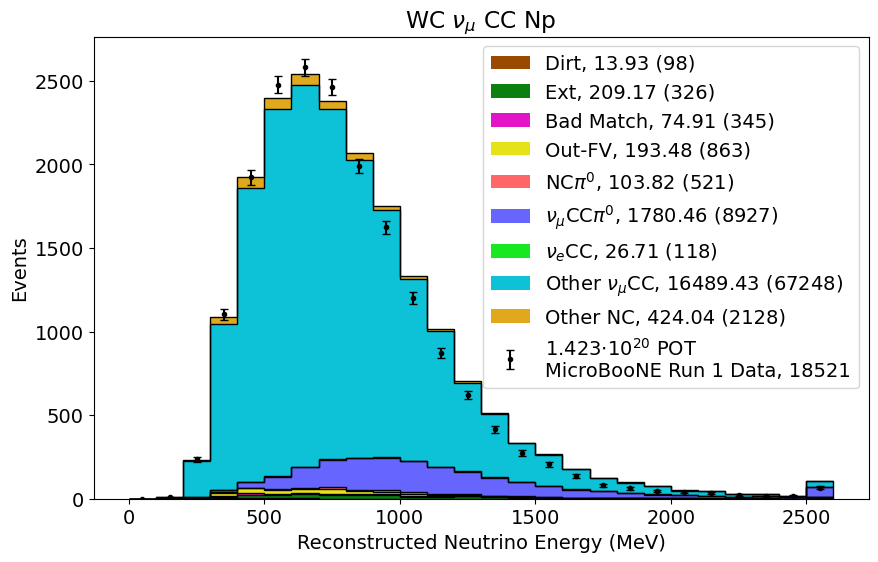

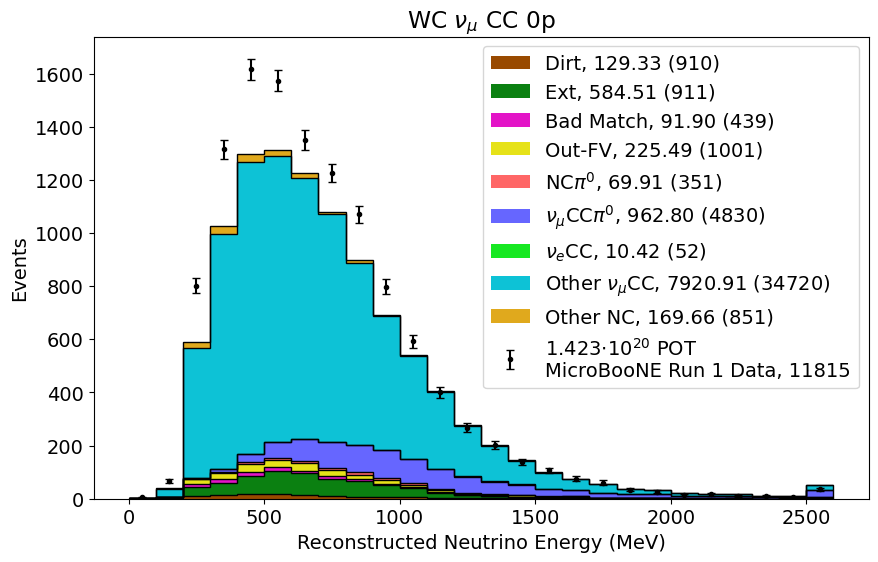

In [9]:
x_variable = "kine_reco_Enu"
x_variable_name = "Reconstructed Neutrino Energy (MeV)"
bins = np.linspace(0, 2500, 26)

plt.rcParams.update({'font.size': 14})

# name for legend, query to choose predicted events, color 
# (I recommend using the VS Code extension "Color Highlight" to see the hex color in your editor) (I usually google "color picker" and use that to choose hex colors)
breakdown_categories = [
    "Dirt",                 "file=='dirt'",                                                                                                                                                     "#994a00",
    "Ext",                  "file=='ext'",                                                                                                                                                      "#0b8011",
    "Bad Match",            "file=='nu_overlay' and match_completeness_energy< 0.1*truth_energyInside",                                                                                         "#e314c7",
    "Out-FV",               "file=='nu_overlay' and match_completeness_energy>=0.1*truth_energyInside and truth_vtxInside==0",                                                                  "#e6e219",
    r"NC$\pi^0$",           "file=='nu_overlay' and match_completeness_energy>=0.1*truth_energyInside and truth_vtxInside==1 and truth_isCC==0 and truth_NprimPio>0",                           "#ff6666",
    r"$\nu_\mu$CC$\pi^0$",  "file=='nu_overlay' and match_completeness_energy>=0.1*truth_energyInside and truth_vtxInside==1 and truth_isCC==1 and truth_NprimPio>0 and abs(truth_nuPdg)==14",  "#6666ff",
    r"$\nu_e$CC",           "file=='nu_overlay' and match_completeness_energy>=0.1*truth_energyInside and truth_vtxInside==1 and truth_isCC==1 and abs(truth_nuPdg)==12",                       "#17e822",
    r"Other $\nu_\mu$CC",   "file=='nu_overlay' and match_completeness_energy>=0.1*truth_energyInside and truth_vtxInside==1 and truth_isCC==1 and abs(truth_nuPdg)==14 and truth_NprimPio==0", "#0dc2d6",
    "Other NC",             "file=='nu_overlay' and match_completeness_energy>=0.1*truth_energyInside and truth_vtxInside==1 and truth_isCC==0 and truth_NprimPio==0",                          "#e0a91d",
]

names = breakdown_categories[::3]
queries = breakdown_categories[1::3]
colors = breakdown_categories[2::3]
colors_k = ["k" for _ in range(len(colors))]
num_categories = len(names)

bin_width = bins[1] - bins[0]
bin_centers = (bins[:-1] + bins[1:]) / 2
bins = np.append(bins, 1e9) # adding overflow bin
display_bins = np.append(bins[:-1], bins[-2]+bin_width) # making the overflow bin appear as another bin of normal width
bin_centers = np.append(bin_centers, bin_centers[-1]+bin_width)
bin_centers_categories = [bin_centers for _ in range(num_categories)]

sel_query_names = [
    "numu_cc_flag >= 0 and numu_score > 0.9 and WC_reco_num_protons > 0", r"WC $\nu_\mu$ CC Np",
    "numu_cc_flag >= 0 and numu_score > 0.9 and WC_reco_num_protons == 0", r"WC $\nu_\mu$ CC 0p",
]

sel_queries = sel_query_names[::2]
sel_names = sel_query_names[1::2]

for sel_i in range(len(sel_queries)):
    sel_df = all_df.query(sel_queries[sel_i])
    sel_pred_df = sel_df.query("file!='data'")
    sel_data_df = sel_df.query("file=='data'")

    label_names = []
    counts_categories = []
    for q_i, query in enumerate(queries):

        hist = np.histogram(sel_pred_df.query(query)[x_variable], bins=bins, weights=sel_pred_df.query(query)["net_weight"])[0]
        count_weighted = np.sum(hist)
        count_unweighted = len(sel_pred_df.query(query))

        counts_categories.append(hist)
        label_names.append(f"{names[q_i]}, {np.sum(counts_categories[-1]):.2f} ({count_unweighted})")

    data_counts = np.histogram(sel_data_df[x_variable], bins=bins)[0]
    data_error = np.sqrt(data_counts)

    plt.figure(figsize=(10, 6))
    plt.hist(bin_centers_categories, weights=counts_categories, bins=display_bins, stacked=True, color=colors, label=label_names)
    plt.hist(bin_centers_categories, weights=counts_categories, bins=display_bins, stacked=True, color=colors_k, histtype="step")
    plt.errorbar(bin_centers, data_counts, yerr=data_error, capsize=3, color="k", fmt=".", label=f"{data_POT/1e20:.3f}"r"$\cdot{10}^{20}$ POT""\nMicroBooNE Run 1 Data"f", {len(sel_data_df)}")
    plt.xlabel(x_variable_name)
    plt.ylabel("Events")
    plt.legend()
    plt.title(sel_names[sel_i])
    plt.savefig(f"plots/{sel_names[sel_i]}.png")
    
# These should be similar to plots in this paper: https://journals.aps.org/prd/abstract/10.1103/PhysRevD.110.013006


# Plotting Efficiency

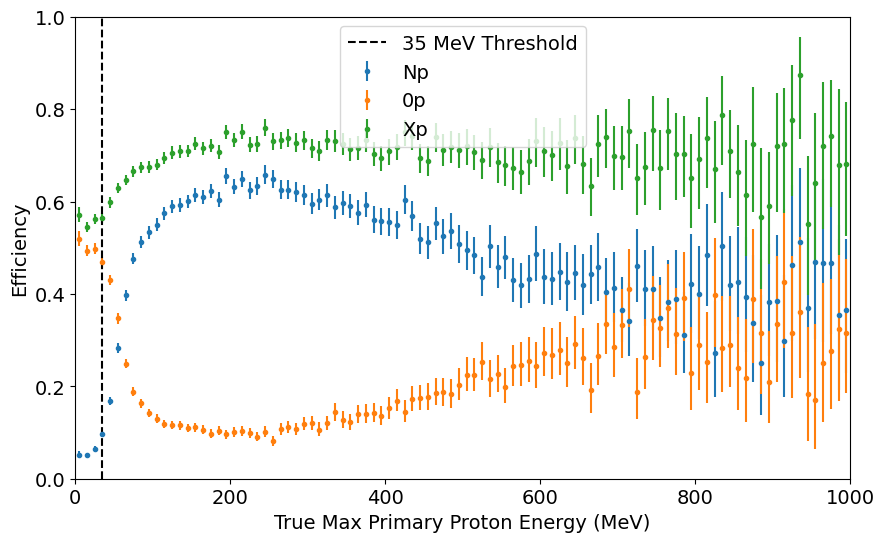

In [10]:
true_Np_df = all_df.query("max_prim_proton_energy > 0 and truth_nuPdg == 14 and truth_isCC == 1 and truth_vtxInside == 1")
Xp_sel_true_Np_df = true_Np_df.query("numu_cc_flag >= 0 and numu_score > 0.9")
Np_sel_true_Np_df = Xp_sel_true_Np_df.query("WC_reco_num_protons > 0")
zerop_sel_true_Np_df = Xp_sel_true_Np_df.query("WC_reco_num_protons == 0")
not_numuCC_sel_true_Np_df = true_Np_df.query("not(numu_cc_flag >= 0 and numu_score > 0.9)")

bins = np.linspace(0, 1000, 101)
bin_centers = (bins[:-1] + bins[1:]) / 2

all_true_Kp = np.histogram(true_Np_df["max_prim_proton_energy"], weights=true_Np_df["net_weight"], bins=bins)[0]
Np_sel_true_Kp = np.histogram(Np_sel_true_Np_df["max_prim_proton_energy"], weights=Np_sel_true_Np_df["net_weight"], bins=bins)[0]
zerop_sel_true_Kp = np.histogram(zerop_sel_true_Np_df["max_prim_proton_energy"], weights=zerop_sel_true_Np_df["net_weight"], bins=bins)[0]
Xp_sel_true_Kp = np.histogram(Xp_sel_true_Np_df["max_prim_proton_energy"], weights=Xp_sel_true_Np_df["net_weight"], bins=bins)[0]

unweighted_all_true_Kp = np.histogram(true_Np_df["max_prim_proton_energy"], bins=bins)[0]
unweighted_Np_sel_true_Kp = np.histogram(Np_sel_true_Np_df["max_prim_proton_energy"], bins=bins)[0]
unweighted_zerop_sel_true_Kp = np.histogram(zerop_sel_true_Np_df["max_prim_proton_energy"], bins=bins)[0]
unweighted_Xp_sel_true_Kp = np.histogram(Xp_sel_true_Np_df["max_prim_proton_energy"], bins=bins)[0]

unweighted_frac_Np = unweighted_Np_sel_true_Kp / unweighted_all_true_Kp
unweighted_frac_zerop = unweighted_zerop_sel_true_Kp / unweighted_all_true_Kp
unweighted_frac_Xp = unweighted_Xp_sel_true_Kp / unweighted_all_true_Kp

weighted_frac_Np = Np_sel_true_Kp / all_true_Kp
weighted_frac_zerop = zerop_sel_true_Kp / all_true_Kp
weighted_frac_Xp = Xp_sel_true_Kp / all_true_Kp

Np_lows, Np_highs = [], []
zerop_lows, zerop_highs = [], []
Xp_lows, Xp_highs = [], []

for i in range(len(bin_centers)):

    # Using Clopper-Pearson (aka "exact") confidence intervals for binomial statistical uncertainties
    # This uncertainty is evaluated without event weights, but then adjusted fractionally to account for any changes due to event weights
    
    unweighted_Np_binom_ci = binomtest(unweighted_Np_sel_true_Kp[i], unweighted_all_true_Kp[i]).proportion_ci()
    unweighted_Np_low, unweighted_Np_high = unweighted_Np_binom_ci.low, unweighted_Np_binom_ci.high
    unweighted_zerop_binom_ci = binomtest(unweighted_zerop_sel_true_Kp[i], unweighted_all_true_Kp[i]).proportion_ci()
    unweighted_zerop_low, unweighted_zerop_high = unweighted_zerop_binom_ci.low, unweighted_zerop_binom_ci.high
    unweighted_Xp_binom_ci = binomtest(unweighted_Xp_sel_true_Kp[i], unweighted_all_true_Kp[i]).proportion_ci()
    unweighted_Xp_low, unweighted_Xp_high = unweighted_Xp_binom_ci.low, unweighted_Xp_binom_ci.high

    Np_low = unweighted_Np_low * weighted_frac_Np[i] / unweighted_frac_Np[i]
    Np_high = unweighted_Np_high * weighted_frac_Np[i] / unweighted_frac_Np[i]
    zerop_low = unweighted_zerop_low * weighted_frac_zerop[i] / unweighted_frac_zerop[i]
    zerop_high = unweighted_zerop_high * weighted_frac_zerop[i] / unweighted_frac_zerop[i]
    Xp_low = unweighted_Xp_low * weighted_frac_Xp[i] / unweighted_frac_Xp[i]
    Xp_high = unweighted_Xp_high * weighted_frac_Xp[i] / unweighted_frac_Xp[i]

    Np_lows.append(Np_low)
    Np_highs.append(Np_high)
    zerop_lows.append(zerop_low)
    zerop_highs.append(zerop_high)
    Xp_lows.append(Xp_low)
    Xp_highs.append(Xp_high)

plt.figure(figsize=(10, 6))
plt.errorbar(bin_centers, weighted_frac_Np, yerr=[weighted_frac_Np - Np_lows, Np_highs - weighted_frac_Np], fmt=".", label="Np")
plt.errorbar(bin_centers, weighted_frac_zerop, yerr=[weighted_frac_zerop - zerop_lows, zerop_highs - weighted_frac_zerop], fmt=".", label="0p")
plt.errorbar(bin_centers, weighted_frac_Xp, yerr=[weighted_frac_Xp - Xp_lows, Xp_highs - weighted_frac_Xp], fmt=".", label="Xp")
plt.axvline(35, c="k", linestyle="--", label="35 MeV Threshold")
plt.xlabel("True Max Primary Proton Energy (MeV)")
plt.ylabel("Efficiency")
plt.legend()
plt.xlim(bins[0], bins[-1])
plt.ylim(0, 1)
plt.show()

# This should be similar to a plot in this paper: https://journals.aps.org/prd/abstract/10.1103/PhysRevD.110.013006


# Particle-level Information

In [11]:
# A lot of the information in these files comes from detailed processing of raw WC spacepoints, which are not saved in these files.
# We do save some basic information about each WC reco particle. 
# This type of information is the input to the new RNN-based energy estimator: https://arxiv.org/abs/2406.10123

# Let's look at one event, passing the WC NC Pi0 selection:

one_event_df = pred_df.query("file=='nu_overlay' and run==7003 and subrun==45 and event==2269")	

print("High-level information:")
display(one_event_df[["file", "run", "subrun", "event", "kine_reco_Enu", "truth_nuEnergy", "nue_score", "numu_score", "nc_delta_score", "nc_pio_score"]])

print("Reconstructed particles:")
display(one_event_df[["reco_Ntrack", "reco_id", "reco_mother", "reco_pdg", "reco_startMomentum", "reco_startXYZT", "reco_endXYZT"]])

# reco_Ntrack shows us that we have 13 reconstructed particles, so each variable is a vector of length 13. 
# Each of these has an id and a mother, which form a tree structure. Each of these has a reco pdg describing the type of particle,
# a reco momentum 4-vector describing the reconstructed energy and direction, and a reco start and end XYZT 4-vector, which give the reconstructed position and time.

# We also have the same information for truth particles:

print("True particles:")
display(one_event_df[["truth_Ntrack", "truth_id", "truth_pdg", "truth_mother", "truth_startMomentum", "truth_startXYZT", "truth_endXYZT"]])

# There is even more information in the files, for example truth_process that can tell you more about what process created a particle, but we won't use that in this tutorial.


High-level information:


,file,run,subrun,event,kine_reco_Enu,truth_nuEnergy,nue_score,numu_score,nc_delta_score,nc_pio_score
14341,nu_overlay,7003,45,2269,342.795685,622.154663,-inf,-1.065909,-6.5076,5.170193


Reconstructed particles:


,reco_Ntrack,reco_id,reco_mother,reco_pdg,reco_startMomentum,reco_startXYZT,reco_endXYZT
14341,13,"[34020, 28004, 36022, 38024, 39025, 96026, 340...","[34031, 28032, 36033, 38034, 39035, 96036, 0, ...","[11, 11, 2212, 2212, 2212, 2212, 111, 22, 22, ...","[[-0.042589094, -0.02182987, 0.1815339, 0.1877...","[[155.22824, 91.70978, 284.81512, 0.0], [78.73...","[[128.79245, 106.93065, 332.37692, 0.0], [39.3..."


True particles:


,truth_Ntrack,truth_id,truth_pdg,truth_mother,truth_startMomentum,truth_startXYZT,truth_endXYZT
14341,94.0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[14, 2212, 2212, 2212, 2212, 2212, 2212, 2112,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-0.19286755, -0.043995135, 0.17892176, 0.266...","[[157.847, 90.87858, 274.97415, 3715.9634], [1...","[[-74364.24, -16858.797, 69219.4, 7144.3745], ..."


# Particle-level Trees

Reconstructed Particle Tree:

pi0 126.13 MeV
    gamma 187.23 MeV
        e- 187.23 MeV
    gamma 130.43 MeV
        e- 130.43 MeV
n 4.25 MeV
    p 4.25 MeV
n 18.32 MeV
    p 18.32 MeV
n 2.57 MeV
    p 2.57 MeV
n 0.00 MeV
    p 0.00 MeV

Truth Particle Tree:

nu(mu) 266.73 MeV
p 3.84 MeV
p 1.07 MeV
p 15.13 MeV
p 2.28 MeV
p 8.91 MeV
p 4.58 MeV
n 6.45 MeV
    n 2.09 MeV
        n 0.54 MeV
        Ar40 -9.12 MeV
    Ar40 -8.98 MeV
n 15.28 MeV
    n 0.71 MeV
    n 0.29 MeV
    Ar39 -8.77 MeV
n 6.05 MeV
    n 2.70 MeV
        Cr53 -12.12 MeV
        Ar40 -9.05 MeV
    Ar40 -9.00 MeV
n 19.98 MeV
    Ar40 -9.06 MeV
    n 4.34 MeV
        n 1.22 MeV
            Ar40 -9.07 MeV
            Ar40 -9.09 MeV
        Ar40 -9.14 MeV
    n 1.76 MeV
        Ar40 -9.09 MeV
        Ar40 -9.07 MeV
        Ar40 -9.07 MeV
        Ar40 -9.11 MeV
        Ar40 -9.10 MeV
        Ar40 -9.09 MeV
        Ar40 -9.11 MeV
        Ar40 -9.11 MeV
        p 0.07 MeV
        p 0.11 MeV
    Ar39 -8.89 MeV
n 0.88 MeV
n 9.29

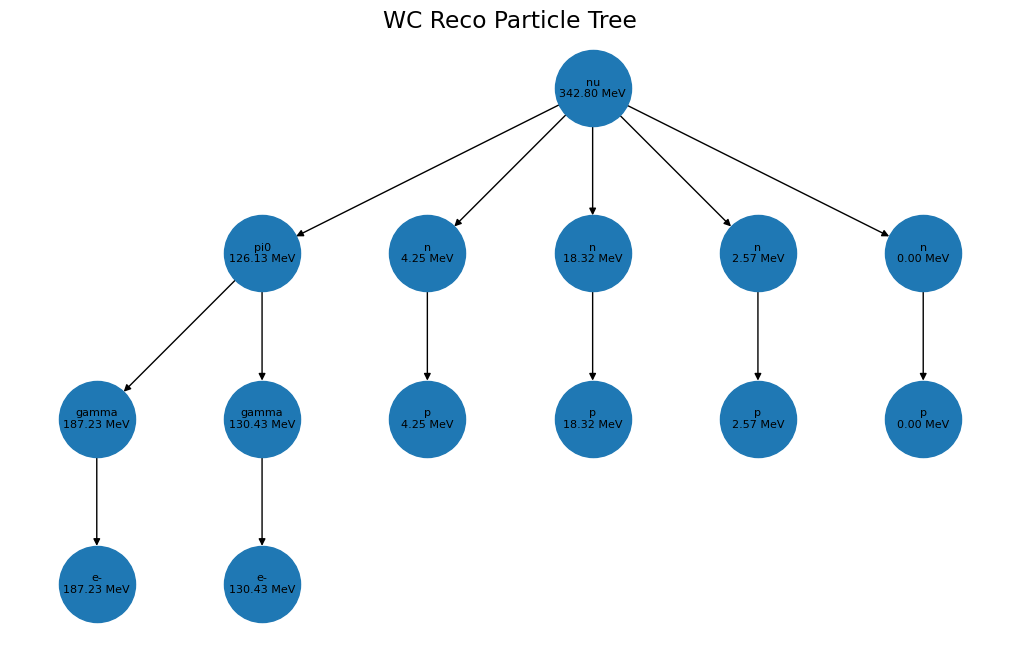

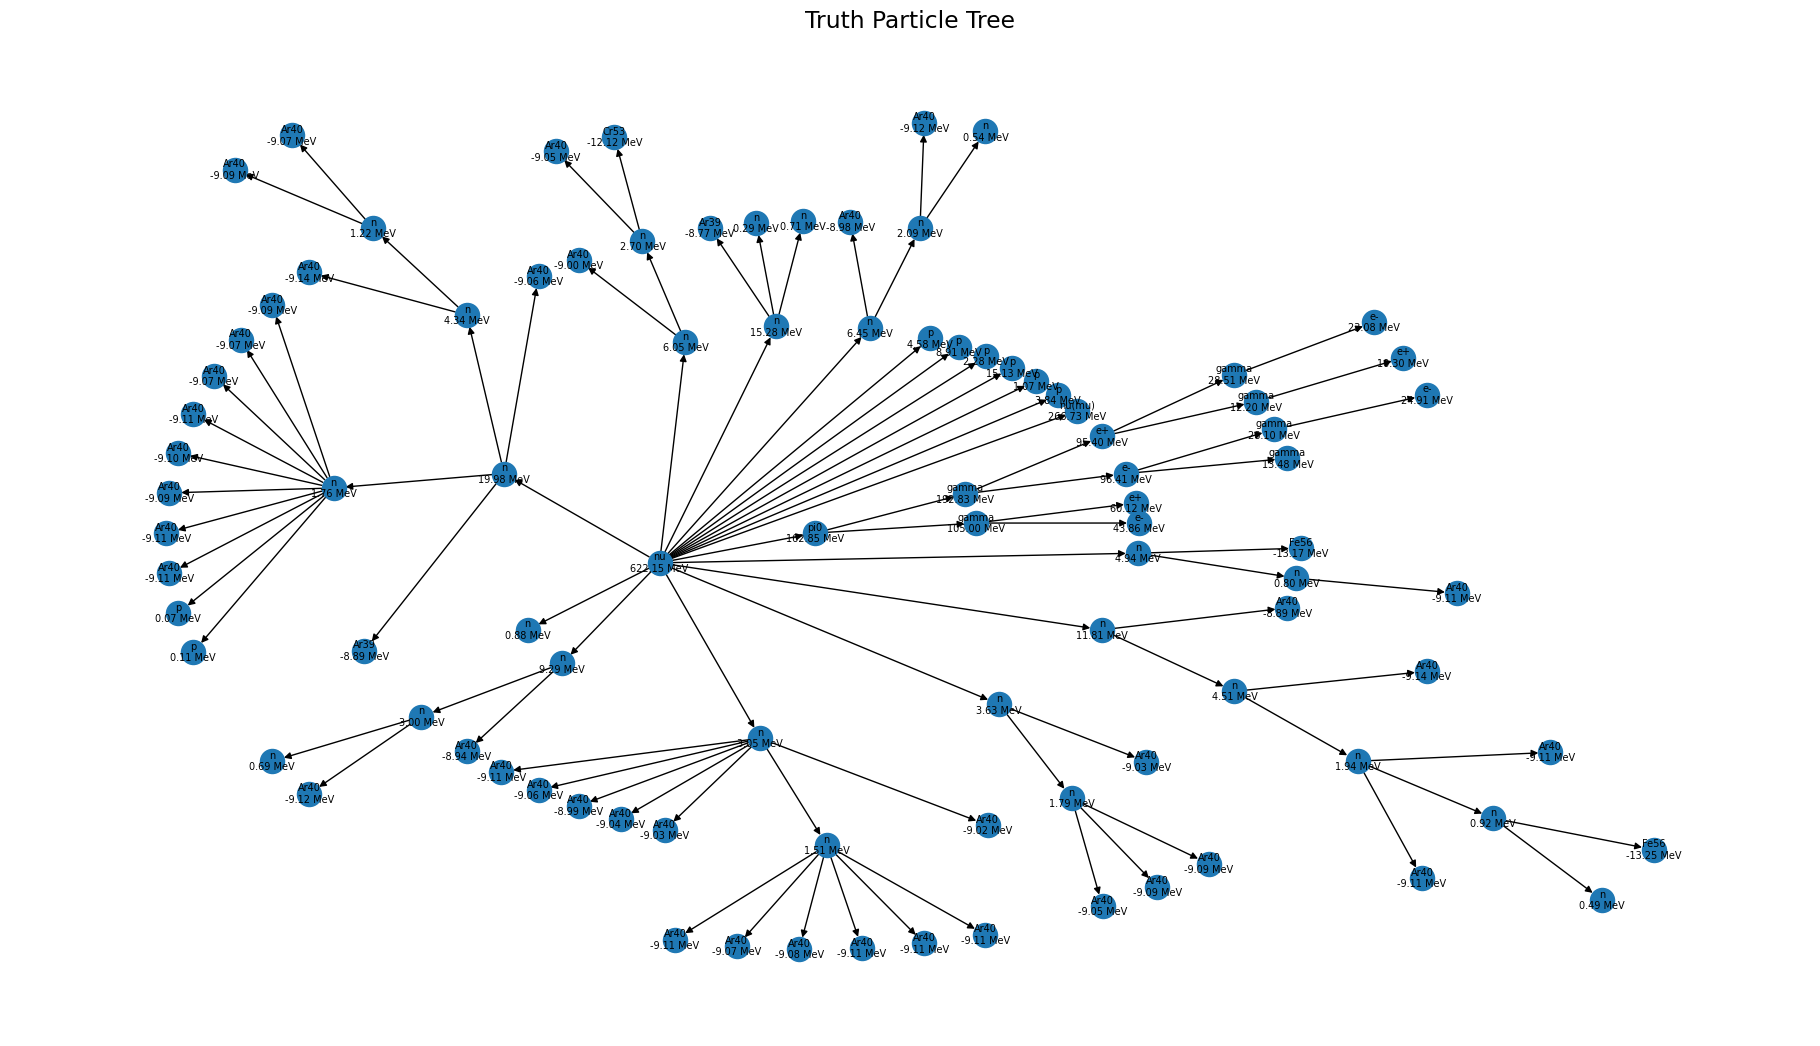

In [12]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from particle import Particle

def print_particle_tree(curr_id, ids, mothers, pdgs, start_momentums, spaces=""):
    for i in range(len(ids)):
        if ids[i] == curr_id: # found current particle
            name = Particle.from_pdgid(pdgs[i]).name
            energy = start_momentums[i][3]*1000
            mass = Particle.from_pdgid(pdgs[i]).mass
            if mass == None:
                mass = 0
            KE = energy - mass
            print(f"{spaces}{name} {KE:.2f} MeV")
            for j in range(len(pdgs)):
                if mothers[j] == curr_id: # found daughter particle
                    print_particle_tree(ids[j], ids, mothers, pdgs, start_momentums, spaces + "    ")

def print_particle_trees(event_df, reco=True, truth=True):
    for event_i in range(event_df.shape[0]):
        row = event_df.iloc[event_i]
        reco_ids = row["reco_id"]
        reco_mothers = row["reco_mother"]
        reco_pdgs = row["reco_pdg"]
        reco_start_momentums = row["reco_startMomentum"]
        truth_ids = row["truth_id"]
        truth_mothers = row["truth_mother"]
        truth_pdgs = row["truth_pdg"]
        truth_start_momentums = row["truth_startMomentum"]
        if reco:
            print("Reconstructed Particle Tree:\n")
            for particle_i in range(len(reco_ids)):
                if reco_mothers[particle_i] == 0:
                    print_particle_tree(reco_ids[particle_i], reco_ids, reco_mothers, reco_pdgs, reco_start_momentums)
        if truth:
            print("\nTruth Particle Tree:\n")
            for particle_i in range(len(truth_ids)):
                if truth_mothers[particle_i] == 0:
                    print_particle_tree(truth_ids[particle_i], truth_ids, truth_mothers, truth_pdgs, truth_start_momentums)


def add_daughters_to_networkx_graph(G, curr_id, ids, mothers, pdgs, start_momentums):
    for j in range(len(ids)):
        if mothers[j] == curr_id: # found daughter particle
            name = Particle.from_pdgid(pdgs[j]).name
            energy = start_momentums[j][3]*1000
            mass = Particle.from_pdgid(pdgs[j]).mass
            if mass == None:
                mass = 0
            KE = energy - mass
            G.add_node(ids[j], pname=name, KE=KE, mass=mass)
            G.add_edge(curr_id, ids[j])
            add_daughters_to_networkx_graph(G, ids[j], ids, mothers, pdgs, start_momentums)

print_particle_trees(one_event_df, reco=True, truth=True)

G = nx.DiGraph()
G.add_node(0, pname="nu", KE=one_event_df["kine_reco_Enu"].to_numpy()[0])
add_daughters_to_networkx_graph(G, 0, one_event_df["reco_id"].to_numpy()[0], one_event_df["reco_mother"].to_numpy()[0], one_event_df["reco_pdg"].to_numpy()[0], one_event_df["reco_startMomentum"].to_numpy()[0])
plt.figure(figsize=(10, 6))
pos = graphviz_layout(G, prog="dot")
node_pnames = nx.get_node_attributes(G, 'pname')
node_KEs = nx.get_node_attributes(G, 'KE')
custom_labels = {node: f"{node_pnames[node]}\n{node_KEs[node]:.2f} MeV" for node in G.nodes()}
nx.draw(G, pos, with_labels=False, node_size=3000)
nx.draw_networkx_labels(G, pos, labels=custom_labels, font_size=8, font_color='black')
plt.title("WC Reco Particle Tree")
plt.show()


G = nx.DiGraph()
G.add_node(0, pname="nu", KE=one_event_df["truth_nuEnergy"].to_numpy()[0])
add_daughters_to_networkx_graph(G, 0, one_event_df["truth_id"].to_numpy()[0], one_event_df["truth_mother"].to_numpy()[0], one_event_df["truth_pdg"].to_numpy()[0], one_event_df["truth_startMomentum"].to_numpy()[0])
plt.figure(figsize=(18, 10))
pos = nx.spring_layout(G)
pos = graphviz_layout(G, prog="twopi")
node_pnames = nx.get_node_attributes(G, 'pname')
node_KEs = nx.get_node_attributes(G, 'KE')
custom_labels = {node: f"{node_pnames[node]}\n{node_KEs[node]:.2f} MeV" for node in G.nodes()}
nx.draw(G, pos, with_labels=False, node_size=300)
font_sizes = {node: 7 for node in G.nodes()}
for node, label in custom_labels.items():
    nx.draw_networkx_labels(G, pos, labels={node: custom_labels[node]}, font_size=font_sizes[node], font_color='black')
plt.title("Truth Particle Tree")
plt.show()


# Simplified Event Display

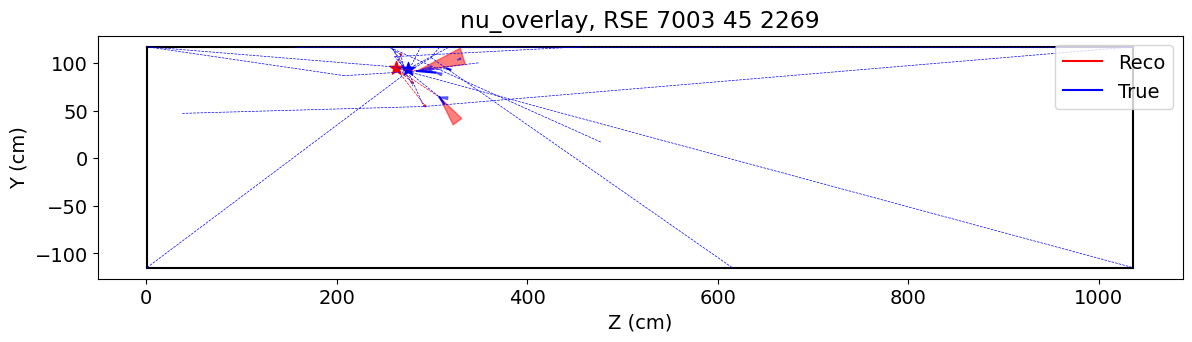

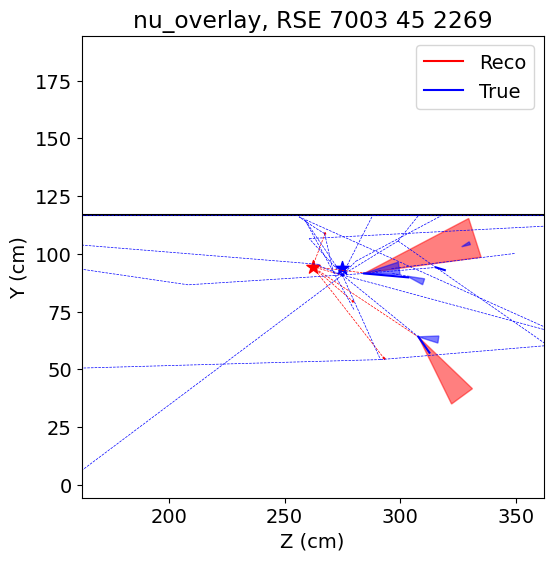

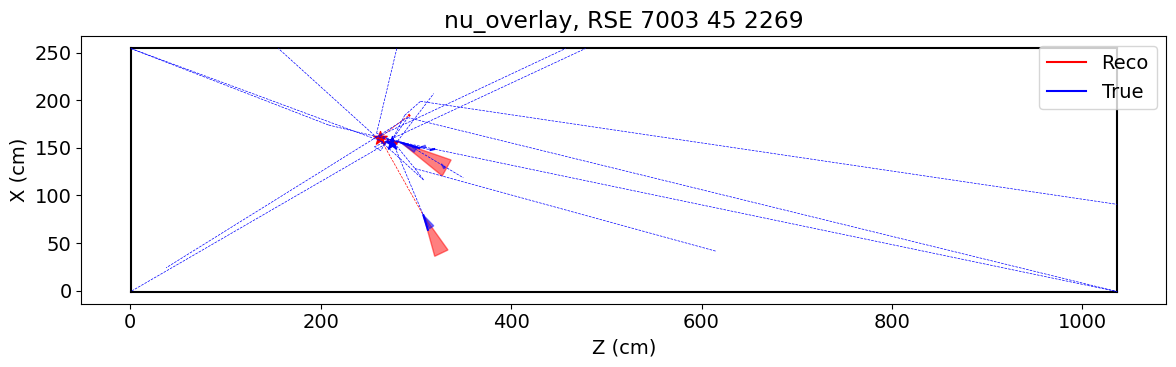

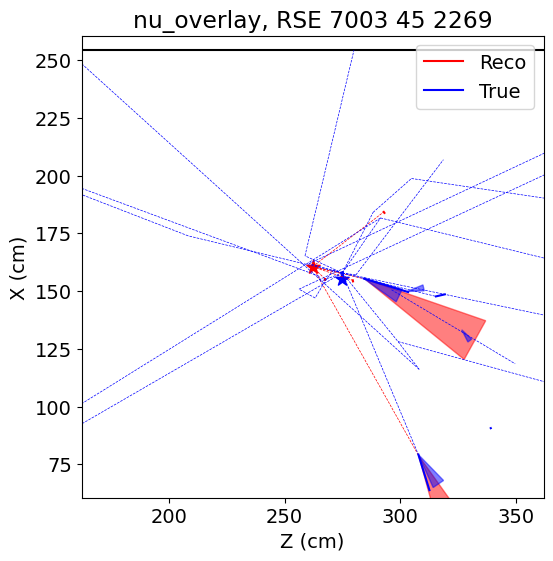

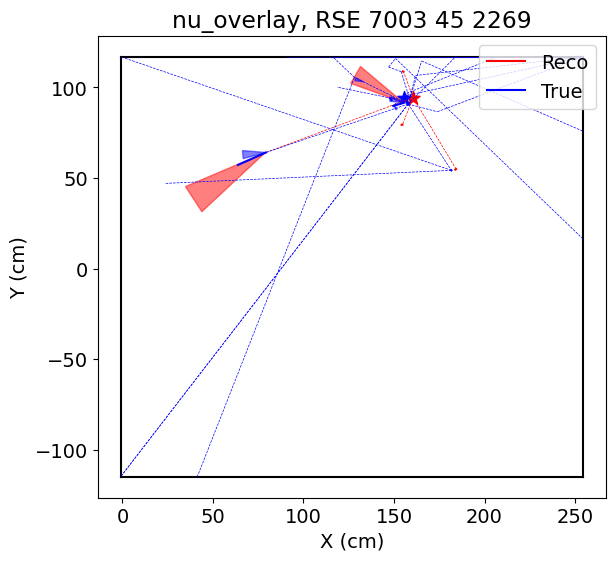

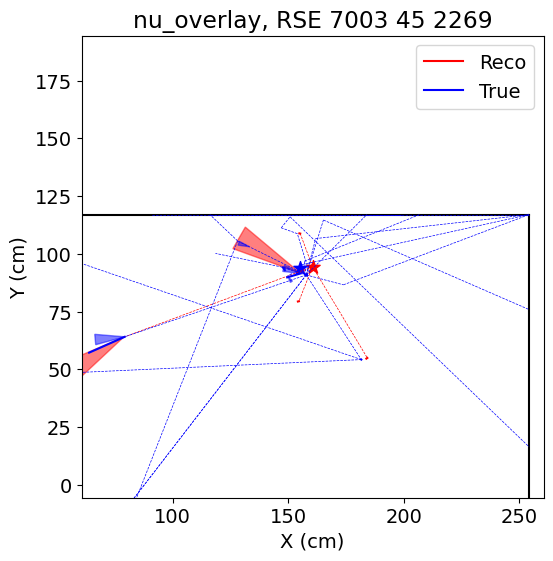

In [13]:
def show_simplified_event_display(one_event_df, view="zy", zoomed=False):

    file = one_event_df["file"].to_numpy()[0]
    run = one_event_df["run"].to_numpy()[0]
    subrun = one_event_df["subrun"].to_numpy()[0]
    event = one_event_df["event"].to_numpy()[0]

    reco_ids = one_event_df["reco_id"].to_numpy()[0]
    reco_pdgs = one_event_df["reco_pdg"].to_numpy()[0]
    reco_start_XYZTs = one_event_df["reco_startXYZT"].to_numpy()[0]
    reco_end_XYZTs = one_event_df["reco_endXYZT"].to_numpy()[0]

    truth_ids = one_event_df["truth_id"].to_numpy()[0]
    truth_pdgs = one_event_df["truth_pdg"].to_numpy()[0]
    truth_start_XYZTs = one_event_df["truth_startXYZT"].to_numpy()[0]
    truth_end_XYZTs = one_event_df["truth_endXYZT"].to_numpy()[0]

    tpc_min_x = -1.
    tpc_max_x = 254.3
    tpc_min_y = -115.
    tpc_max_y = 117.
    tpc_min_z = 0.6
    tpc_max_z = 1036.4

    plt.rcParams.update({'font.size': 14})

    plt.figure(figsize=(14, 6))
    if view == "zy":
        plt.plot([tpc_min_z, tpc_max_z], [tpc_min_y, tpc_min_y], c="k")
        plt.plot([tpc_min_z, tpc_max_z], [tpc_max_y, tpc_max_y], c="k")
        plt.plot([tpc_min_z, tpc_min_z], [tpc_min_y, tpc_max_y], c="k")
        plt.plot([tpc_max_z, tpc_max_z], [tpc_min_y, tpc_max_y], c="k")
    elif view =="zx":
        plt.plot([tpc_min_z, tpc_max_z], [tpc_min_x, tpc_min_x], c="k")
        plt.plot([tpc_min_z, tpc_max_z], [tpc_max_x, tpc_max_x], c="k")
        plt.plot([tpc_min_z, tpc_min_z], [tpc_min_x, tpc_max_x], c="k")
        plt.plot([tpc_max_z, tpc_max_z], [tpc_min_x, tpc_max_x], c="k")
    elif view == "xy":
        plt.plot([tpc_min_x, tpc_max_x], [tpc_min_y, tpc_min_y], c="k")
        plt.plot([tpc_min_x, tpc_max_x], [tpc_max_y, tpc_max_y], c="k")
        plt.plot([tpc_min_x, tpc_min_x], [tpc_min_y, tpc_max_y], c="k")
        plt.plot([tpc_max_x, tpc_max_x], [tpc_min_y, tpc_max_y], c="k")
    plt.plot([], [], c="r", label="Reco")
    plt.plot([], [], c="b", label="True")
    for j in range(len(reco_pdgs)):
        start_x, start_y, start_z, start_t = reco_start_XYZTs[j]
        end_x, end_y, end_z, end_t = reco_end_XYZTs[j]
        if view == "zy":
            start = np.array([start_z, start_y])
            end = np.array([end_z, end_y])
        elif view == "zx":
            start = np.array([start_z, start_x])
            end = np.array([end_z, end_x])
        elif view == "xy":
            start = np.array([start_x, start_y])
            end = np.array([end_x, end_y])
        pdg = reco_pdgs[j]
        if Particle.from_pdgid(pdg).charge == 0: # invisible particle, draw dashed line
            plt.plot([start[0], end[0]], [start[1], end[1]], c="r", linestyle="--", lw=0.5)
        elif pdg == 11: # shower, plot cone
            direction = end - start
            length = np.linalg.norm(direction)
            unit_direction = direction / length
            perp = np.array([-unit_direction[1], unit_direction[0]])
            angle_rad = np.radians(20 / 2)
            side_length = length * np.tan(angle_rad)
            side1 = end - side_length * perp
            side2 = end + side_length * perp
            triangle = np.array([start, side1, end, side2])
            plt.fill(triangle[:, 0], triangle[:, 1], color="r", alpha=0.5)
        else: # track, plot line
            plt.plot([start[0], end[0]], [start[1], end[1]], c="r")

    for j in range(len(truth_pdgs)):
        start_x, start_y, start_z, start_t = truth_start_XYZTs[j]
        end_x, end_y, end_z, end_t = truth_end_XYZTs[j]
        start_x = np.clip(start_x, tpc_min_x, tpc_max_x)
        start_y = np.clip(start_y, tpc_min_y, tpc_max_y)
        start_z = np.clip(start_z, tpc_min_z, tpc_max_z)
        end_x = np.clip(end_x, tpc_min_x, tpc_max_x)
        end_y = np.clip(end_y, tpc_min_y, tpc_max_y)
        end_z = np.clip(end_z, tpc_min_z, tpc_max_z)
        if view == "zy":
            start = np.array([start_z, start_y])
            end = np.array([end_z, end_y])
        elif view == "zx":
            start = np.array([start_z, start_x])
            end = np.array([end_z, end_x])
        elif view == "xy":
            start = np.array([start_x, start_y])
            end = np.array([end_x, end_y])
        pdg = truth_pdgs[j]
        if Particle.from_pdgid(pdg).charge == 0: # invisible particle, draw dashed line
            plt.plot([start[0], end[0]], [start[1], end[1]], c="b", linestyle="--", lw=0.5)
        elif pdg == 11: # shower, plot cone
            direction = end - start
            length = np.linalg.norm(direction)
            unit_direction = direction / length
            perp = np.array([-unit_direction[1], unit_direction[0]])
            angle_rad = np.radians(20 / 2)
            side_length = length * np.tan(angle_rad)
            side1 = end - side_length * perp
            side2 = end + side_length * perp
            triangle = np.array([start, side1, end, side2])
            plt.fill(triangle[:, 0], triangle[:, 1], color="b", alpha=0.5)
        else: # track, plot line
            plt.plot([start[0], end[0]], [start[1], end[1]], c="b")

    if view == "zy":
        plt.scatter(one_event_df["reco_nuvtxZ"].to_numpy()[0], one_event_df["reco_nuvtxY"].to_numpy()[0], color="r", marker="*", s=100)
        plt.scatter(one_event_df["truth_vtxZ"].to_numpy()[0], one_event_df["truth_vtxY"].to_numpy()[0], color="b", marker="*", s=100)
    elif view == "zx":
        plt.scatter(one_event_df["reco_nuvtxZ"].to_numpy()[0], one_event_df["reco_nuvtxX"].to_numpy()[0], color="r", marker="*", s=100)
        plt.scatter(one_event_df["truth_vtxZ"].to_numpy()[0], one_event_df["truth_vtxX"].to_numpy()[0], color="b", marker="*", s=100)
    elif view == "xy":
        plt.scatter(one_event_df["reco_nuvtxX"].to_numpy()[0], one_event_df["reco_nuvtxY"].to_numpy()[0], color="r", marker="*", s=100)
        plt.scatter(one_event_df["truth_vtxX"].to_numpy()[0], one_event_df["truth_vtxY"].to_numpy()[0], color="b", marker="*", s=100)
    plt.title(f"{file}, RSE {run} {subrun} {event}")
    plt.legend(loc="upper right")
    if view == "zy":
        plt.xlabel("Z (cm)")
        plt.ylabel("Y (cm)")
    elif view == "zx":
        plt.xlabel("Z (cm)")
        plt.ylabel("X (cm)")
    elif view == "xy":
        plt.xlabel("X (cm)")
        plt.ylabel("Y (cm)")
    if zoomed and view == "zy":
        plt.xlim(one_event_df["reco_nuvtxZ"].to_numpy()[0]-100, one_event_df["reco_nuvtxZ"].to_numpy()[0]+100)
        plt.ylim(one_event_df["reco_nuvtxY"].to_numpy()[0]-100, one_event_df["reco_nuvtxY"].to_numpy()[0]+100)
    elif zoomed and view == "zx":
        plt.xlim(one_event_df["reco_nuvtxZ"].to_numpy()[0]-100, one_event_df["reco_nuvtxZ"].to_numpy()[0]+100)
        plt.ylim(one_event_df["reco_nuvtxX"].to_numpy()[0]-100, one_event_df["reco_nuvtxX"].to_numpy()[0]+100)
    elif zoomed and view == "xy":
        plt.xlim(one_event_df["reco_nuvtxX"].to_numpy()[0]-100, one_event_df["reco_nuvtxX"].to_numpy()[0]+100)
        plt.ylim(one_event_df["reco_nuvtxY"].to_numpy()[0]-100, one_event_df["reco_nuvtxY"].to_numpy()[0]+100)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

show_simplified_event_display(one_event_df, view="zy", zoomed=False)
show_simplified_event_display(one_event_df, view="zy", zoomed=True)

show_simplified_event_display(one_event_df, view="zx", zoomed=False)
show_simplified_event_display(one_event_df, view="zx", zoomed=True)

show_simplified_event_display(one_event_df, view="xy", zoomed=False)
show_simplified_event_display(one_event_df, view="xy", zoomed=True)


# BEE Event Displays

Beyond the scope of this tutorial. But here's an example to try playing around with:

https://www.phy.bnl.gov/twister/bee/set/uboone/reco/2021-01/pr-1/event/3/ (publicly advertised already, from https://microboone.fnal.gov/wp-content/uploads/MICROBOONE-NOTE-1100-PUB-1.pdf figure 5).

And here's a reference explaining how to make your own BEE event displays:

celltree to BEE (for reconstructed particles): https://docs.google.com/document/d/1jNmBqXuNngZk4sPqk8Ps87_bPqZinXL5_IeFC5Xb6vs/edit#heading=h.s8ydywlelr5i

artroot to BEE (for truth particles): https://docs.google.com/document/d/1T-__tCrazXoLGUeJ5ol4xlGKHMxlepX2sDVy3ufMt8g/edit


# Adding Systematics

Beyond the scope of this tutorial. Much more work to set up and run than everything else here, but here are some references for how you might get started, but it's probably easiest to talk to WC people for help with this.

Xin's summary of analysis steps: https://www.phy.bnl.gov/xqian/talks/wire-cell/LEEana/readme

Hanyu's tutorial video: https://indico.bnl.gov/event/10045/
  
Hanyu's and Xiangpan's tutorial google doc: https://docs.google.com/document/d/1sgr_OBzNYnGG1qi1mX_wIUHIPJDSDRetNSzmcZQk9Ik/edit

TLee tutorial google doc: https://docs.google.com/document/d/1dqo7GFlz8g85D-lsjlqZRP57avBI2dDq6S8VMANAr-Q/edit#heading=h.ldw9jixqbcg0edit#heading=h.ldw9jixqbcg0
